In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
Dtrain = pd.read_csv('Dtrain.csv')
Dtest = pd.read_csv('Dtest.csv')

In [3]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [4]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [5]:
sclr = StandardScaler(copy=True)
sclr2 = StandardScaler(with_mean=False)

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

## Bag of Words

### Loading the data

In [7]:
Dtrain_bow = sparse.load_npz('BOW_train.npz')
Dtest_bow = sparse.load_npz('BOW_test.npz')

In [8]:
yTrain_bow = Dtrain.Polarity
yTest_bow = Dtest.Polarity

### Scaling the data

In [9]:
sclr2.fit(Dtrain_bow)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [10]:
Dtrain_scaled_bow = sclr2.transform(Dtrain_bow)
Dtest_scaled_bow = sclr2.transform(Dtest_bow)

In [11]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}

In [12]:
estimator = SGDClassifier(random_state=42)

In [13]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [14]:
features = Dtrain_scaled_bow
labels = yTrain_bow.apply(lambda x: 1 if x == 'positive' else 0).values

In [15]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.8s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.9s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=4.49

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.1s


[CV] ...................... alpha=4.291934260128778e-05, total=   1.1s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   0.5s
[CV] ..................... alpha=2.0235896477251556e-05, total=   2.2s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.5s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   1.1s
[CV] alpha=0.00019306977288832496 ....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.9s
[CV] alpha=0.00019306977288832496 ....................................
[CV] ..................... alpha=0.00019306977288832496, total=   0.8s
[CV] .

[CV] alpha=0.35564803062231287 .......................................
[CV] alpha=0.35564803062231287 .......................................
[CV] ........................ alpha=0.35564803062231287, total=   1.3s
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.16768329368110066, total=   2.5s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.16768329368110066, total=   2.4s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.7s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   2.1s
[CV] ......................... alpha=0.7543120063354607, total=   1.5s
[CV] alpha=1.5998587196060574 ........................................
[CV] a

[CV] alpha=2947.0517025518097 ........................................
[CV] .......................... alpha=655.1285568595496, total=   2.3s
[CV] ......................... alpha=1389.4954943731361, total=   1.6s
[CV] alpha=2947.0517025518097 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   1.3s
[CV] ......................... alpha=2947.0517025518097, total=   1.3s
[CV] alpha=2947.0517025518097 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   2.3s
[CV] ......................... alpha=2947.0517025518097, total=   1.6s
[CV] alpha=6250.5519252739505 ........................................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   51.4s


[CV] ......................... alpha=2947.0517025518097, total=   1.5s
[CV] ......................... alpha=6250.5519252739505, total=   0.8s
[CV] alpha=6250.5519252739505 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.6s
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   1.0s
[CV] alpha=13257.113655901054 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.1s
[CV] alpha=13257.113655901054 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   1.5s
[CV] ......................... alpha=13257.113655901054, total=   1.2s
[CV] .

[CV] alpha=51794746.79231202 .........................................
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=24420530.94548645, total=   1.7s
[CV] ......................... alpha=11513953.993264433, total=   2.1s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=24420530.94548645, total=   1.7s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=51794746.79231202, total=   1.3s
[CV] .......................... alpha=24420530.94548645, total=   1.7s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=51794746.79231202, total=   1.4s
[CV] alpha=109854114.19875573 ........................................
[CV] alpha=109854114.19875573 ........................................
[CV] .......................... alpha=24420530.94548645, total=   2.2s
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([1.00000e-06, 2.12095e-06, 4.49843e-06, 9.54095e-06, 2.02359e-05,
       4.29193e-05, 9.10298e-05, 1.93070e-04, 4.09492e-04, 8.68511e-04,
       1.84207e-03, 3.90694e-03, 8.28643e-03, 1.75751e-02, 3.72759e-02,
       7.90604e-02, 1.67683e-01, 3.55648e-01, 7.54312e-01, 1.59... 1.09854e+08, 2.32995e+08,
       4.94171e+08, 1.04811e+09, 2.22300e+09, 4.71487e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'accuracy', 'precision', 

In [16]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

Iter #  train_accuracy  test_accuracy  train_precision  test_precision  \
16      17        0.953471       0.892137         0.954514        0.904352   
15      16        0.959932       0.891907         0.962820        0.911392   
17      18        0.944171       0.887717         0.943446        0.893827   
14      15        0.963984       0.887434         0.968951        0.915207   
18      19        0.930151       0.877740         0.927882        0.878948   

    train_recall  test_recall  train_f1   test_f1  fit_time  score_time  \
16      0.993870     0.975127  0.973787  0.938407  1.547415    0.128938   
15      0.992233     0.965611  0.977299  0.937718  1.562031    0.143764   
17      0.995518     0.983576  0.968775  0.936555  1.631719    0.113047   
14      0.990288     0.954907  0.979497  0.934635  1.693465    0.109798   
18      0.997283     0.991434  0.961320  0.931806  1.623949    0.169118   

       alpha  
16  0.167683  
15  0.079060  
17  0.355648  
14  0.037276  
18  0.754312

In [17]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

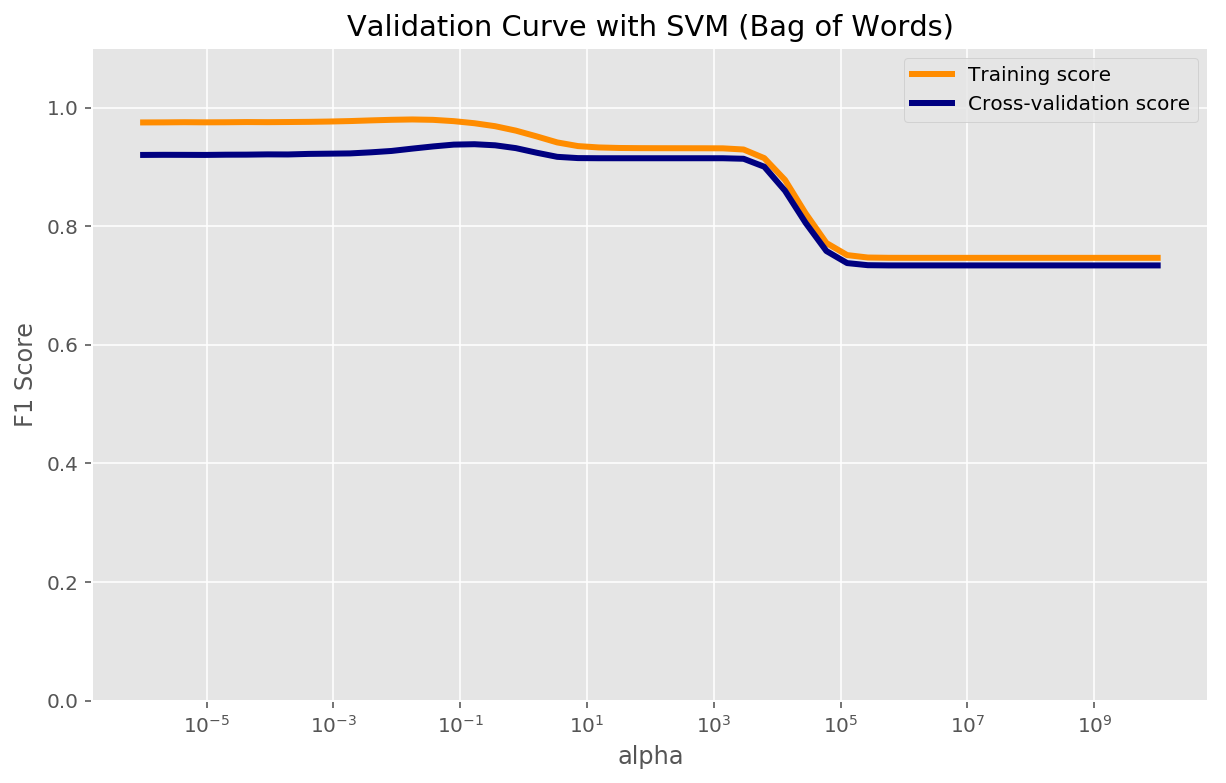

In [19]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM (Bag of Words)")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [20]:
grid.best_estimator_

SGDClassifier(alpha=0.16768329368110066, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [21]:
joblib.dump(grid.best_estimator_, 'bow_best.model')

['bow_best.model']

## TFIDF

### Loading the data

In [22]:
Dtrain_tfidf = sparse.load_npz('tfidf_train.npz')
Dtest_tfidf = sparse.load_npz('tfidf_test.npz')

In [23]:
yTrain_tfidf = Dtrain.Polarity
yTest_tfidf = Dtest.Polarity

### Scaling the data

In [24]:
sclr2.fit(Dtrain_tfidf)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [25]:
Dtrain_scaled_tfidf = sclr2.transform(Dtrain_tfidf)
Dtest_scaled_tfidf = sclr2.transform(Dtest_tfidf)

In [26]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}

In [27]:
estimator = SGDClassifier(random_state=42)

In [28]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    n_iter=50,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [29]:
features = Dtrain_scaled_tfidf
labels = yTrain_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

In [30]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=0.6362198492657483 ........................................
[CV] alpha=0.6362198492657483 ........................................
[CV] alpha=0.6362198492657483 ........................................
[CV] alpha=0.6362198492657483 ........................................
[CV] ......................... alpha=0.6362198492657483, total=   0.5s
[CV] alpha=0.6362198492657483 ........................................
[CV] ......................... alpha=0.6362198492657483, total=   0.5s
[CV] alpha=16.384336455779813 ........................................
[CV] alpha=16.384336455779813 ........................................
[CV] alpha=16.384336455779813 ........................................
[CV] alpha=16.384336455779813 ........................................
[CV] ......................... alpha=0.6362198492657483, total=   1.0s
[CV] ......................... alpha=16.384336455779813, total=   0.6s
[CV] alpha=16.3

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.5s


[CV] alpha=31549900.64958082 .........................................
[CV] ...................... alpha=7.340598369757212e-06, total=   1.1s
[CV] ..................... alpha=2.0636177678638567e-05, total=   1.9s
[CV] alpha=31549900.64958082 .........................................
[CV] alpha=31549900.64958082 .........................................
[CV] alpha=0.0021610725088083765 .....................................
[CV] .......................... alpha=31549900.64958082, total=   1.1s
[CV] alpha=0.0021610725088083765 .....................................
[CV] .......................... alpha=31549900.64958082, total=   1.1s
[CV] alpha=0.0021610725088083765 .....................................
[CV] ...................... alpha=7.340598369757212e-06, total=   1.9s
[CV] alpha=0.0021610725088083765 .....................................
[CV] ...................... alpha=0.0021610725088083765, total=   1.1s
[CV] ...................... alpha=7.340598369757212e-06, total=   2.0s
[CV] a

[CV] .......................... alpha=0.509817606442042, total=   0.9s
[CV] alpha=0.509817606442042 .........................................
[CV] alpha=0.0008276289456246343 .....................................
[CV] alpha=0.0008276289456246343 .....................................
[CV] alpha=0.0008276289456246343 .....................................
[CV] .......................... alpha=45637162.81924754, total=   2.5s
[CV] alpha=0.0008276289456246343 .....................................
[CV] ...................... alpha=0.0008276289456246343, total=   0.7s
[CV] alpha=0.0008276289456246343 .....................................
[CV] .......................... alpha=0.509817606442042, total=   1.6s
[CV] ...................... alpha=0.0008276289456246343, total=   1.1s
[CV] alpha=289015971.79095 ...........................................
[CV] .......................... alpha=0.509817606442042, total=   1.8s
[CV] alpha=289015971.79095 ...........................................
[CV] a

[CV] .......................... alpha=172374470.8063613, total=   1.0s
[CV] .......................... alpha=314.0465219496749, total=   1.6s
[CV] alpha=172374470.8063613 .........................................
[CV] ..................... alpha=3.7770636945393648e-06, total=   2.5s
[CV] alpha=21117.83044448242 .........................................
[CV] .......................... alpha=21117.83044448242, total=   0.3s
[CV] alpha=21117.83044448242 .........................................
[CV] .......................... alpha=172374470.8063613, total=   1.6s
[CV] .......................... alpha=314.0465219496749, total=   2.1s
[CV] alpha=21117.83044448242 .........................................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   51.2s


[CV] alpha=21117.83044448242 .........................................
[CV] .......................... alpha=314.0465219496749, total=   2.6s
[CV] alpha=21117.83044448242 .........................................
[CV] .......................... alpha=172374470.8063613, total=   2.3s
[CV] alpha=2850426320.8534317 ........................................
[CV] alpha=2850426320.8534317 ........................................
[CV] .......................... alpha=172374470.8063613, total=   2.5s
[CV] .......................... alpha=21117.83044448242, total=   1.8s
[CV] alpha=2850426320.8534317 ........................................
[CV] alpha=2850426320.8534317 ........................................
[CV] .......................... alpha=172374470.8063613, total=   2.7s
[CV] .......................... alpha=21117.83044448242, total=   1.6s
[CV] alpha=2850426320.8534317 ........................................
[CV] alpha=160106446.1318311 .........................................
[CV] .

[CV] ......................... alpha=521716857.55543333, total=   2.0s
[CV] ......................... alpha=521716857.55543333, total=   2.2s
[CV] alpha=0.03573602246065781 .......................................
[CV] ......................... alpha=18.991405823619317, total=   1.5s
[CV] alpha=0.03573602246065781 .......................................
[CV] ........................ alpha=0.03573602246065781, total=   0.8s
[CV] alpha=0.03573602246065781 .......................................
[CV] ......................... alpha=18.991405823619317, total=   1.6s
[CV] alpha=0.03573602246065781 .......................................
[CV] alpha=0.05169241873891593 .......................................
[CV] alpha=0.05169241873891593 .......................................
[CV] ........................ alpha=0.03573602246065781, total=   1.3s
[CV] ........................ alpha=0.03573602246065781, total=   0.7s
[CV] alpha=0.05169241873891593 .......................................
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=8,
          param_distributions={'alpha': array([1.00000e-06, 1.07662e-06, ..., 9.28829e+09, 1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'accuracy', 'precision', 'recall', 'f1'}, verbose=2)

In [31]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

train_accuracy  test_accuracy  train_precision  test_precision  \
48        0.950634       0.884652         0.950939        0.896797   
38        0.942276       0.880664         0.940978        0.887540   
17        0.936687       0.876850         0.934611        0.881319   
43        0.962964       0.881008         0.968073        0.911335   
24        0.933479       0.874557         0.931105        0.877863   

    train_recall  test_recall  train_f1   test_f1  fit_time  score_time  \
48      0.994576     0.975370  0.972251  0.934431  1.414185    0.133830   
38      0.996171     0.982920  0.967769  0.932793  1.206708    0.117218   
17      0.997041     0.986709  0.964794  0.931033  1.440087    0.099246   
43      0.990038     0.951426  0.978923  0.930944  1.477790    0.107492   
24      0.997408     0.988665  0.963093  0.929965  1.614511    0.181897   

       alpha  
48  0.226313  
38  0.379453  
17  0.509818  
43  0.051692  
24  0.590940

In [32]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [33]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

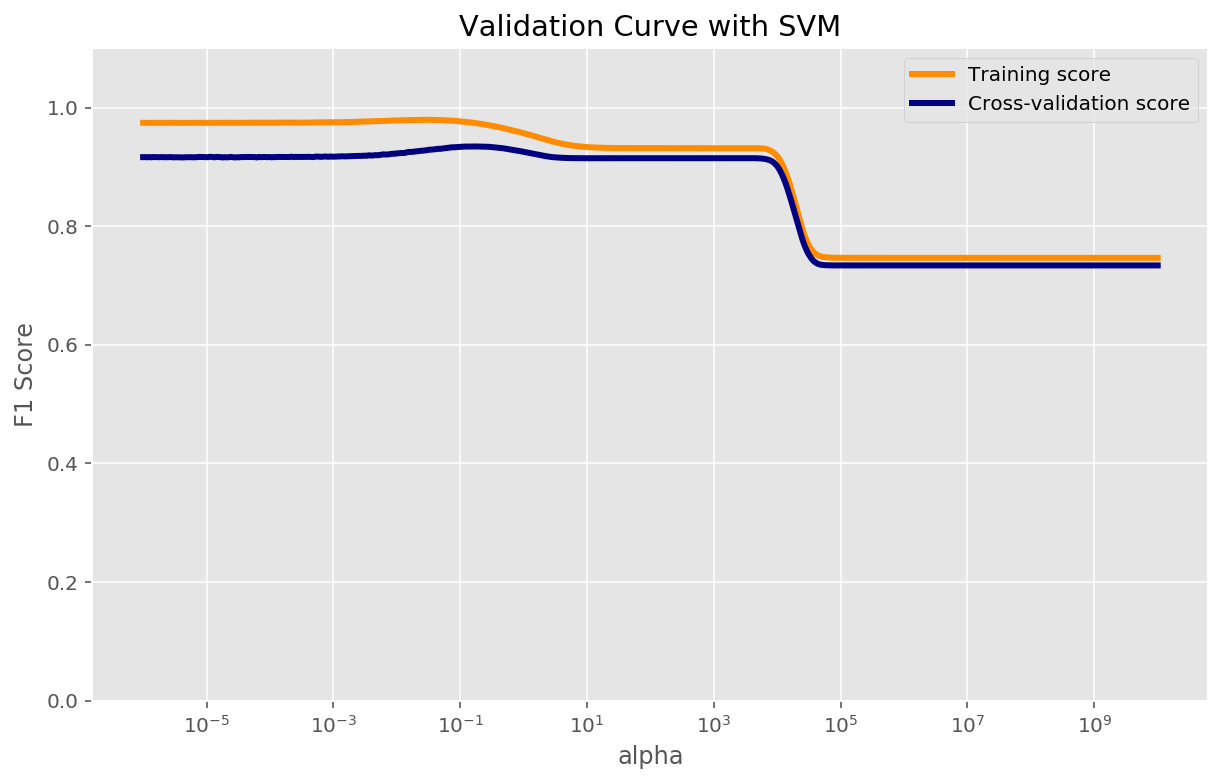

In [34]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [35]:
grid.best_estimator_

SGDClassifier(alpha=0.2263129568399525, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [36]:
joblib.dump(grid.best_estimator_, 'tfidf_best.model')

['tfidf_best.model']

## Avg. Word2Vec

### Loading the data

In [37]:
Dtain_avg_w2v = pd.read_csv('AvgW2V_train.csv')
Dtest_avg_w2v = pd.read_csv('AvgW2V_test.csv')

### Scaling the data

In [38]:
yTrain_avg_w2v = Dtain_avg_w2v.Label
yTest_avg_w2v = Dtest_avg_w2v.Label

Dtain_avg_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_avg_w2v.drop(['Label'], inplace=True, axis=1)

sclr.fit(Dtain_avg_w2v)

Dtrain_scaled_avg_w2v = sclr.transform(Dtain_avg_w2v)
Dtest_scaled_avg_w2v = sclr.transform(Dtest_avg_w2v)

### GridSearch

In [39]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}
estimator = SGDClassifier(random_state=42)

In [40]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [41]:
features = Dtrain_scaled_avg_w2v
labels = yTrain_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [42]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.6s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.6s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.8s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=4.49

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s


[CV] ..................... alpha=2.0235896477251556e-05, total=   1.6s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.4s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.1s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   0.8s
[CV] alpha=0.00019306977288832496 ....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.2s
[CV] alpha=0.00019306977288832496 ....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   1.2s
[CV] a

[CV] ........................ alpha=0.16768329368110066, total=   1.4s
[CV] ........................ alpha=0.35564803062231287, total=   0.6s
[CV] alpha=0.35564803062231287 .......................................
[CV] ........................ alpha=0.16768329368110066, total=   1.8s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.1s
[CV] ........................ alpha=0.16768329368110066, total=   1.5s
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.4s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.8s
[CV] ......................... alpha=0.7543120063354607, total=   0.9s
[CV] a

[CV] alpha=2947.0517025518097 ........................................
[CV] .......................... alpha=655.1285568595496, total=   2.0s
[CV] .......................... alpha=655.1285568595496, total=   2.1s
[CV] alpha=2947.0517025518097 ........................................
[CV] alpha=2947.0517025518097 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.2s
[CV] ......................... alpha=1389.4954943731361, total=   1.9s
[CV] alpha=6250.5519252739505 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   1.8s
[CV] ......................... alpha=2947.0517025518097, total=   1.4s
[CV] alpha=6250.5519252739505 ........................................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   41.9s


[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.8s
[CV] ......................... alpha=6250.5519252739505, total=   1.0s
[CV] alpha=6250.5519252739505 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.9s
[CV] ......................... alpha=6250.5519252739505, total=   1.1s
[CV] ......................... alpha=6250.5519252739505, total=   1.4s
[CV] ......................... alpha=1389.4954943731361, total=   2.7s
[CV] alpha=13257.113655901054 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.6s
[CV] alpha=13257.113655901054 ........................................
[CV] a

[CV] alpha=51794746.79231202 .........................................
[CV] ......................... alpha=11513953.993264433, total=   1.5s
[CV] alpha=51794746.79231202 .........................................
[CV] ......................... alpha=11513953.993264433, total=   1.9s
[CV] .......................... alpha=24420530.94548645, total=   1.6s
[CV] alpha=51794746.79231202 .........................................
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=24420530.94548645, total=   1.9s
[CV] .......................... alpha=51794746.79231202, total=   1.3s
[CV] .......................... alpha=51794746.79231202, total=   0.9s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=24420530.94548645, total=   1.8s
[CV] alpha=109854114.19875573 ........................................
[CV] alpha=109854114.19875573 ........................................
[CV] a

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([1.00000e-06, 2.12095e-06, 4.49843e-06, 9.54095e-06, 2.02359e-05,
       4.29193e-05, 9.10298e-05, 1.93070e-04, 4.09492e-04, 8.68511e-04,
       1.84207e-03, 3.90694e-03, 8.28643e-03, 1.75751e-02, 3.72759e-02,
       7.90604e-02, 1.67683e-01, 3.55648e-01, 7.54312e-01, 1.59... 1.09854e+08, 2.32995e+08,
       4.94171e+08, 1.04811e+09, 2.22300e+09, 4.71487e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'accuracy', 'precision', 

### Interpretation

In [43]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

Iter #  train_accuracy  test_accuracy  train_precision  test_precision  \
8        9        0.891618       0.872090         0.902400        0.881452   
9       10        0.890638       0.870400         0.898560        0.876800   
7        8        0.889696       0.871182         0.904801        0.884904   
10      11        0.888971       0.868027         0.894710        0.872255   
6        7        0.886905       0.868592         0.909092        0.889534   

    train_recall  test_recall  train_f1   test_f1  fit_time  score_time  \
8       0.981776     0.979975  0.940394  0.928080  1.553813    0.106452   
9       0.985714     0.984465  0.940109  0.927504  1.248759    0.061034   
7       0.976132     0.973836  0.939081  0.927196  1.570806    0.131830   
10      0.988860     0.987996  0.939429  0.926520  1.339635    0.072962   
6       0.967025     0.963947  0.937089  0.925149  1.176300    0.125300   

       alpha  
8   0.000409  
9   0.000869  
7   0.000193  
10  0.001842  
6   0.000091

In [44]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [45]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

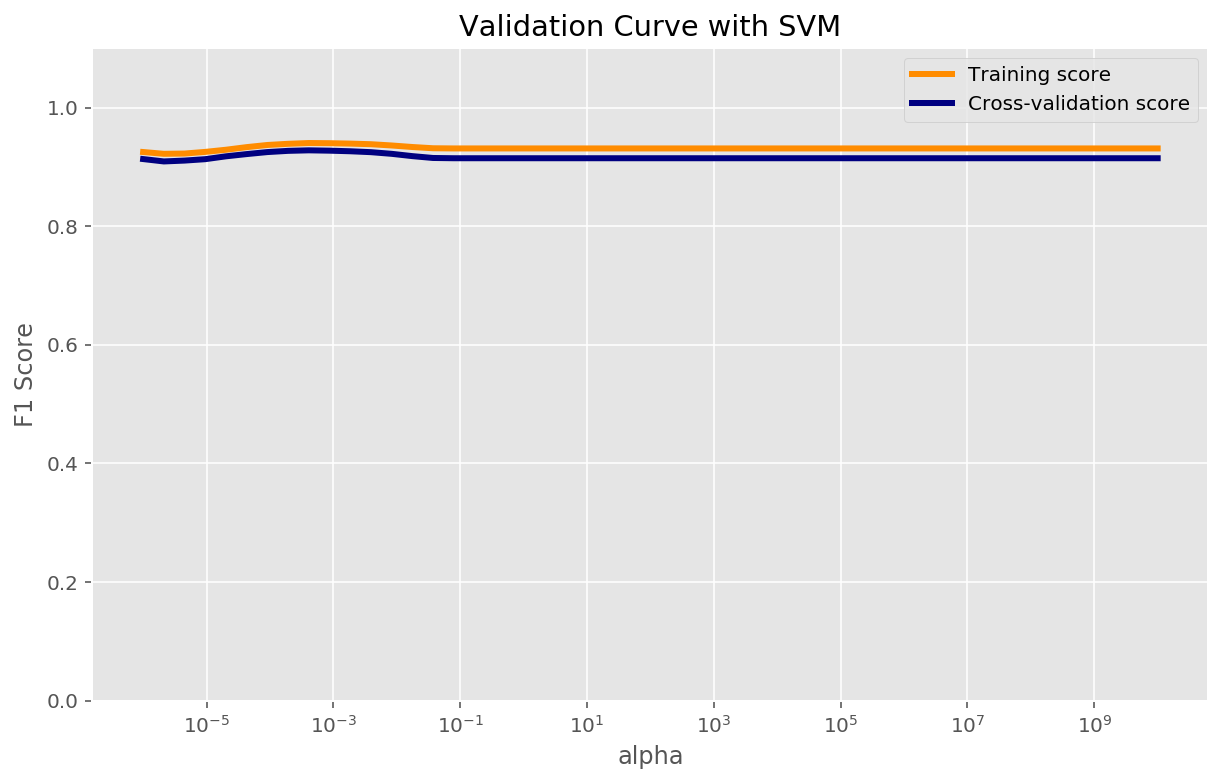

In [46]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [47]:
grid.best_estimator_

SGDClassifier(alpha=0.0004094915062380423, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

#### Saving the best estimator

In [48]:
joblib.dump(grid.best_estimator_, 'avgW2V_best.model')

['avgW2V_best.model']

## TFIDF Word2Vec

### Loading the data

In [49]:
Dtain_tfidf_w2v = pd.read_csv('TFIDF_w2v_train.csv')
Dtest_tfidf_w2v = pd.read_csv('TFIDF_w2v_test.csv')

### Scaling the data

In [50]:
yTrain_TFIDF_w2v = Dtain_tfidf_w2v.Label
yTest_TFIDF_w2v = Dtest_tfidf_w2v.Label
Dtain_tfidf_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_tfidf_w2v.drop(['Label'], inplace=True, axis=1)

sclr.fit(Dtain_tfidf_w2v)

Dtrain_scaled_TFIDF_w2v = sclr.transform(Dtain_tfidf_w2v)
Dtest_scaled_TFIDF_w2v = sclr.transform(Dtest_tfidf_w2v)

### RandomizedSearch

In [51]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}
estimator = SGDClassifier(random_state=42)

In [52]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8,
                    n_iter=50)

In [53]:
features = Dtrain_scaled_TFIDF_w2v
labels = yTrain_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [54]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=1988.8278569888037 ........................................
[CV] alpha=1988.8278569888037 ........................................
[CV] alpha=1988.8278569888037 ........................................
[CV] alpha=1988.8278569888037 ........................................
[CV] alpha=1988.8278569888037 ........................................
[CV] ......................... alpha=1988.8278569888037, total=   1.7s
[CV] alpha=8087.524908770441 .........................................
[CV] alpha=8087.524908770441 .........................................
[CV] ......................... alpha=1988.8278569888037, total=   2.0s
[CV] alpha=8087.524908770441 .........................................
[CV] ......................... alpha=1988.8278569888037, total=   2.2s
[CV] alpha=8087.524908770441 .........................................
[CV] alpha=8087.524908770441 .........................................
[CV] ..........

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   16.3s


[CV] alpha=7.239681140910877e-05 .....................................
[CV] ......................... alpha=33967385.822722025, total=   2.0s
[CV] ..................... alpha=2.0923834803969792e-06, total=   3.5s
[CV] alpha=7.239681140910877e-05 .....................................
[CV] alpha=7.239681140910877e-05 .....................................
[CV] ......................... alpha=33967385.822722025, total=   2.6s
[CV] alpha=7.239681140910877e-05 .....................................
[CV] alpha=7.239681140910877e-05 .....................................
[CV] ......................... alpha=33967385.822722025, total=   2.9s
[CV] ...................... alpha=7.239681140910877e-05, total=   2.6s
[CV] ...................... alpha=7.239681140910877e-05, total=   2.0s
[CV] alpha=786668.1790071573 .........................................
[CV] ......................... alpha=33967385.822722025, total=   3.2s
[CV] alpha=786668.1790071573 .........................................
[CV] a

[CV] alpha=279829.68756551103 ........................................
[CV] ......................... alpha=279829.68756551103, total=   1.7s
[CV] ......................... alpha=2305.2893870517014, total=   2.9s
[CV] alpha=279829.68756551103 ........................................
[CV] ......................... alpha=279829.68756551103, total=   2.0s
[CV] alpha=812493021.061403 ..........................................
[CV] ......................... alpha=2305.2893870517014, total=   3.2s
[CV] alpha=812493021.061403 ..........................................
[CV] alpha=812493021.061403 ..........................................
[CV] ......................... alpha=279829.68756551103, total=   2.9s
[CV] alpha=812493021.061403 ..........................................
[CV] alpha=812493021.061403 ..........................................
[CV] ......................... alpha=279829.68756551103, total=   3.3s
[CV] ........................... alpha=812493021.061403, total=   2.5s
[CV] .

[CV] alpha=35407.7390896527 ..........................................
[CV] alpha=35407.7390896527 ..........................................
[CV] .......................... alpha=630375.3153071268, total=   2.8s
[CV] alpha=35407.7390896527 ..........................................
[CV] alpha=35407.7390896527 ..........................................
[CV] .......................... alpha=630375.3153071268, total=   3.0s
[CV] ........................... alpha=35407.7390896527, total=   1.8s
[CV] alpha=35407.7390896527 ..........................................
[CV] alpha=7511.929493320953 .........................................
[CV] .......................... alpha=630375.3153071268, total=   3.4s


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.5min


[CV] ........................... alpha=35407.7390896527, total=   2.7s
[CV] alpha=7511.929493320953 .........................................
[CV] alpha=7511.929493320953 .........................................
[CV] ........................... alpha=35407.7390896527, total=   2.6s
[CV] alpha=7511.929493320953 .........................................
[CV] ........................... alpha=35407.7390896527, total=   2.8s
[CV] alpha=7511.929493320953 .........................................
[CV] .......................... alpha=7511.929493320953, total=   2.5s
[CV] alpha=3557150206.8213825 ........................................
[CV] ........................... alpha=35407.7390896527, total=   3.4s
[CV] .......................... alpha=7511.929493320953, total=   2.6s
[CV] .......................... alpha=7511.929493320953, total=   2.3s
[CV] alpha=3557150206.8213825 ........................................
[CV] alpha=3557150206.8213825 ........................................
[CV] a

[CV] .......................... alpha=421.9398080805024, total=   3.0s
[CV] ....................... alpha=0.005642908471262536, total=   2.3s
[CV] ....................... alpha=0.005642908471262536, total=   1.8s
[CV] alpha=5.882190401699956e-06 .....................................
[CV] .......................... alpha=421.9398080805024, total=   3.7s
[CV] alpha=5.882190401699956e-06 .....................................
[CV] alpha=5.882190401699956e-06 .....................................
[CV] ....................... alpha=0.005642908471262536, total=   2.8s
[CV] alpha=5.882190401699956e-06 .....................................
[CV] ....................... alpha=0.005642908471262536, total=   2.9s
[CV] alpha=5.882190401699956e-06 .....................................
[CV] ...................... alpha=5.882190401699956e-06, total=   2.2s
[CV] alpha=155017.51173357657 ........................................
[CV] ....................... alpha=0.005642908471262536, total=   3.4s
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  2.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=8,
          param_distributions={'alpha': array([1.00000e-06, 1.07662e-06, ..., 9.28829e+09, 1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'accuracy', 'precision', 'recall', 'f1'}, verbose=2)

### Interpretation

In [55]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

train_accuracy  test_accuracy  train_precision  test_precision  \
36        0.898322       0.881384         0.911461        0.894808   
11        0.897710       0.880730         0.912142        0.895029   
15        0.897445       0.879779         0.907759        0.890328   
27        0.897357       0.879619         0.907792        0.890391   
2         0.897016       0.879233         0.906680        0.889203   

    train_recall  test_recall  train_f1   test_f1  fit_time  score_time  \
36      0.978268     0.973623  0.943676  0.932540  2.494097    0.150695   
11      0.976649     0.972489  0.943268  0.932116  2.531969    0.124069   
15      0.982012     0.977688  0.943422  0.931956  2.331313    0.110093   
27      0.981849     0.977378  0.943366  0.931851  2.450092    0.129692   
2       0.982891     0.978530  0.943246  0.931722  2.250007    0.118333   

       alpha  
36  0.000494  
11  0.000317  
15  0.000959  
27  0.001033  
2   0.001289

In [56]:
alphas = grid.cv_results_['param_alpha'].data

In [57]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=alphas,
    cv=tscv, scoring="f1", n_jobs=8)

In [58]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

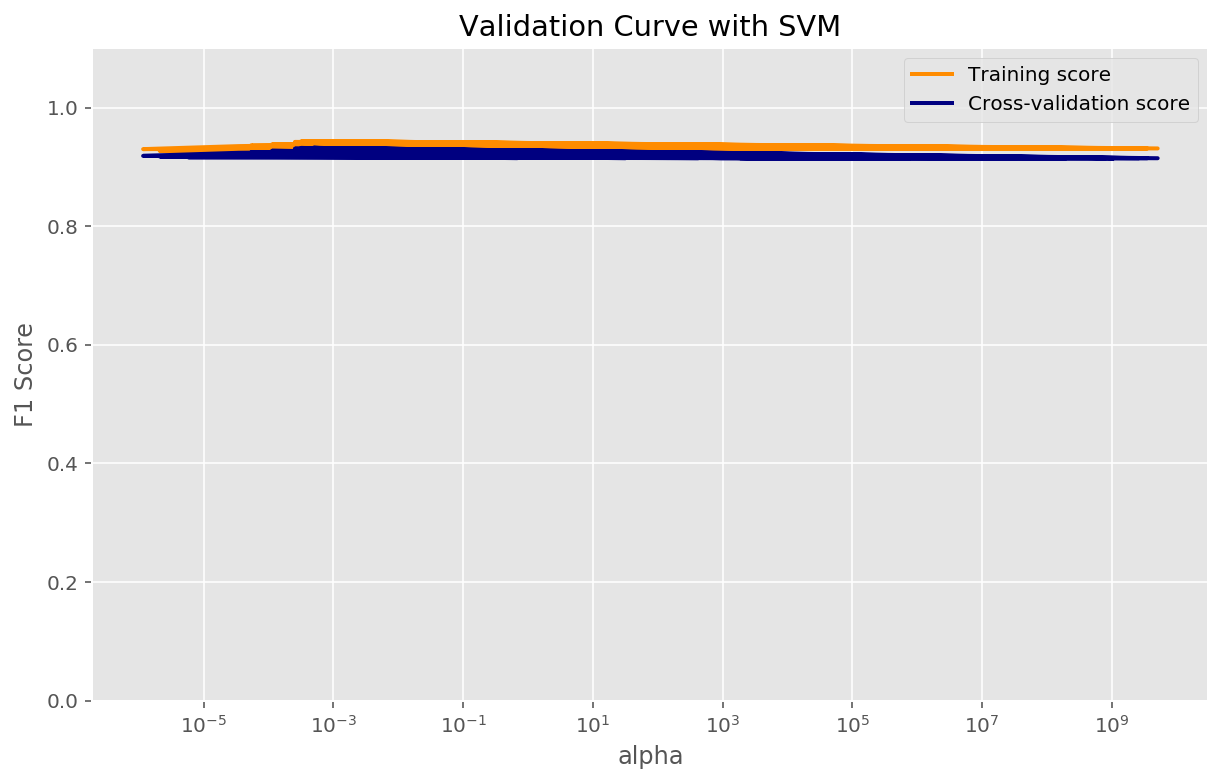

In [59]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(alphas, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(alphas, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [60]:
grid.best_estimator_

SGDClassifier(alpha=0.0004936132098237912, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [61]:
joblib.dump(grid.best_estimator_, 'tfidfW2V_best.model')

['tfidfW2V_best.model']

In [62]:
!ls *.model

avgW2V_best.model  countVectorizer.model  tfidfW2V_best.model
bog_best.model	   tfidf_best.model
bow_best.model	   tfidfVectorizer.model


## Reporting Evaluation metrics for best estimator accoring to F1 score

In [63]:
clf_bow = joblib.load('bow_best.model')
clf_tfidf = joblib.load('tfidf_best.model')
clf_avg_w2v = joblib.load('avgW2V_best.model')
clf_tfidf_w2v = joblib.load('tfidfW2V_best.model')

In [64]:
xTest_bow = Dtest_scaled_bow
actuals_bow = yTest_bow.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf = Dtest_scaled_tfidf
actuals_tfidf = yTest_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_avg_w2v = Dtest_scaled_avg_w2v
actuals_avg_w2v = yTest_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf_w2v = Dtest_scaled_TFIDF_w2v
actuals_tfidf_w2v = yTest_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [65]:
preds_bow = clf_bow.predict(xTest_bow)
preds_tfidf = clf_tfidf.predict(xTest_tfidf)
preds_avg_w2v = clf_avg_w2v.predict(xTest_avg_w2v)
preds_tfidf_w2v = clf_tfidf_w2v.predict(xTest_tfidf_w2v)

In [66]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [67]:
acs_bow = accuracy_score(actuals_bow, preds_bow)
acs_tfidf = accuracy_score(actuals_tfidf, preds_tfidf)
acs_avg_w2v = accuracy_score(actuals_avg_w2v, preds_avg_w2v)
acs_tfidf_w2v = accuracy_score(actuals_tfidf_w2v, preds_tfidf_w2v)


pre_bow = precision_score(actuals_bow, preds_bow)
pre_tfidf = precision_score(actuals_tfidf, preds_tfidf)
pre_avg_w2v = precision_score(actuals_avg_w2v, preds_avg_w2v)
pre_tfidf_w2v = precision_score(actuals_tfidf_w2v, preds_tfidf_w2v)


rec_bow = recall_score(actuals_bow, preds_bow)
rec_tfidf = recall_score(actuals_tfidf, preds_tfidf)
rec_avg_w2v = recall_score(actuals_avg_w2v, preds_avg_w2v)
rec_tfidf_w2v = recall_score(actuals_tfidf_w2v, preds_tfidf_w2v)


f1_bow = f1_score(actuals_bow, preds_bow)
f1_tfidf = f1_score(actuals_tfidf, preds_tfidf)
f1_avg_w2v = f1_score(actuals_avg_w2v, preds_avg_w2v)
f1_tfidf_w2v = f1_score(actuals_tfidf_w2v, preds_tfidf_w2v)

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow])
x.add_row(['TFIDF', acs_tfidf, pre_tfidf, rec_tfidf, f1_tfidf])
x.add_row(['Avg. W2V', acs_avg_w2v, pre_avg_w2v, rec_avg_w2v, f1_avg_w2v])
x.add_row(['TFIDF W2V', acs_tfidf_w2v, pre_tfidf_w2v, rec_tfidf_w2v, f1_tfidf_w2v])
print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Vectorization |      Accuracy      |     Precision      |       Recall       |         F1         |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.890548903291955  | 0.9037794299876084 | 0.9707409050576753 | 0.9360641711229947 |
|     TFIDF     | 0.8810648504156139 | 0.8941728132725824 | 0.9707963620230701 | 0.9309105218935791 |
|    Avg. W2V   | 0.8652641986158409 | 0.8733186186691477 | 0.9787139640389116 | 0.9230173757492703 |
|   TFIDF W2V   | 0.8731370610421473 | 0.8839978659794853 | 0.9741106785131942 | 0.926869168742348  |
+---------------+--------------------+--------------------+--------------------+--------------------+


In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf = pd.DataFrame(confusion_matrix(actuals_tfidf, preds_tfidf),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_avg_w2v = pd.DataFrame(confusion_matrix(actuals_avg_w2v, preds_avg_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf_w2v = pd.DataFrame(confusion_matrix(actuals_tfidf_w2v, preds_tfidf_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

#### Bag Of Words

In [70]:
cm_bow

negative  positive
negative      9758      9318
positive      2638     87522

#### TFIDF

In [71]:
cm_tfidf

negative  positive
negative      8717     10359
positive      2633     87527

#### Avg, W2V

In [72]:
cm_avg_w2v

negative  positive
negative      6284     12799
positive      1919     88234

#### TFIDF W2V

In [73]:
cm_tfidf_w2v

negative  positive
negative      7559     11524
positive      2334     87819